In [ ]:
pip install -U langchain umap-learn scikit-learn langchain_community tiktoken langchain-openai langchainhub chromadb langchain-anthropic

# Load Knowledge about Hayao Miyazaki from Wikipedia

In [42]:
from langchain_community.document_loaders import WikipediaLoader

query = "Hayao Miyazaki"
raw_documents = WikipediaLoader(query=query).load()

In [43]:
# create doc_text as list to store text
doc_text = [d.page_content for d in raw_documents]

In [21]:
from langchain_experimental.graph_transformers.diffbot import DiffbotGraphTransformer

# load Diffbot Token for later entity and relationship extraction
diffbot_api_key = "Diffbot-token"
os.environ["DIFFBOT_API_KEY"] = diffbot_api_key
diffbot_nlp = DiffbotGraphTransformer(diffbot_api_key=diffbot_api_key)

# use Diffbot Graph Transformer to extract entities/relationships from Wikipedia articles
graph_documents = diffbot_nlp.convert_to_graph_documents(raw_documents)

In [134]:
# connect to our neo4j database
from langchain_community.graphs import Neo4jGraph

url = "neo4j-url"
username = "neo4j"
password = "database-pw"

graph = Neo4jGraph(url=url, username=username, password=password)

In [23]:
# import extracted entities and relationships into neo4j graph database
graph.add_graph_documents(graph_documents)

<function matplotlib.pyplot.show(close=None, block=None)>

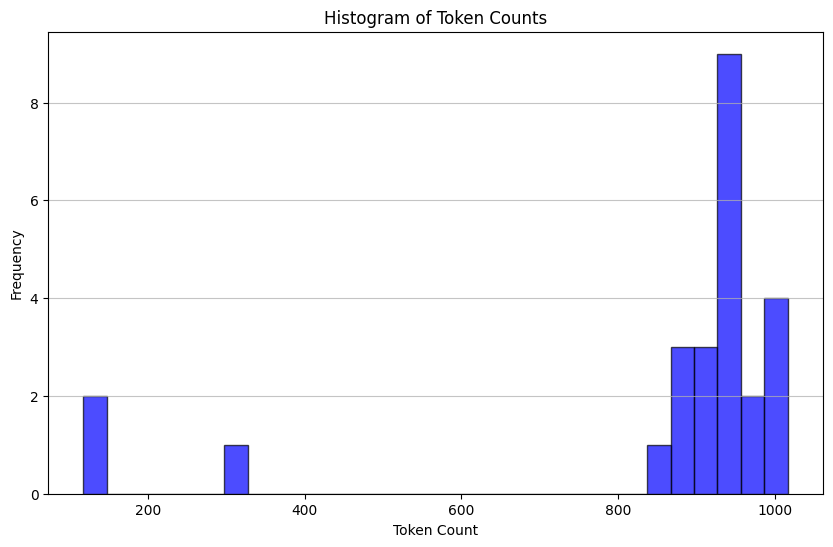

In [52]:
import matplotlib.pyplot as plt
import tiktoken
cnt = [num_tokens_from_string(d, "cl100k_base") for d in doc_text]

# Plotting the histogram of token counts
plt.figure(figsize=(10, 6))
plt.hist(cnt, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)

# Display the histogram
plt.show

In [65]:
# Doc texts concatenated all articles
d_sorted = sorted(raw_documents, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content1 = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content1, "cl100k_base")
)

Num tokens in all context: 21326


In [66]:
# from langchain_text_splitters import RecursiveCharacterTextSplitter

# chunk_size_tok = 2000
# text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
#     chunk_size=chunk_size_tok, chunk_overlap=0
# )
# texts_split = text_splitter.split_text(concatenated_content1)

In [34]:
from langchain_openai import OpenAIEmbeddings
import os

os.environ["OPENAI_API_KEY"] = 'openai-api-key'
os.environ["ANTHROPIC_API_KEY"] = 'anthropic-api-key'
embd = OpenAIEmbeddings()

# from langchain_openai import ChatOpenAI

# model = ChatOpenAI(temperature=0, model="gpt-4-1106-preview")

from langchain_anthropic import ChatAnthropic

model = ChatAnthropic(temperature=0, model="claude-3-opus-20240229")

# functions for embedding at document level, clustering and summarizing

In [68]:
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import umap
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sklearn.mixture import GaussianMixture

RANDOM_SEED = 224  # Fixed seed for reproducibility

### --- Code from citations referenced above (added comments and docstrings) --- ###


def global_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    """
    Perform global dimensionality reduction on the embeddings using UMAP.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - n_neighbors: Optional; the number of neighbors to consider for each point.
                   If not provided, it defaults to the square root of the number of embeddings.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def local_cluster_embeddings(
    embeddings: np.ndarray, dim: int, num_neighbors: int = 10, metric: str = "cosine"
) -> np.ndarray:
    """
    Perform local dimensionality reduction on the embeddings using UMAP, typically after global clustering.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - num_neighbors: The number of neighbors to consider for each point.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    return umap.UMAP(
        n_neighbors=num_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def get_optimal_clusters(
    embeddings: np.ndarray, max_clusters: int = 50, random_state: int = RANDOM_SEED
) -> int:
    """
    Determine the optimal number of clusters using the Bayesian Information Criterion (BIC) with a Gaussian Mixture Model.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - max_clusters: The maximum number of clusters to consider.
    - random_state: Seed for reproducibility.

    Returns:
    - An integer representing the optimal number of clusters found.
    """
    max_clusters = min(max_clusters, len(embeddings))
    n_clusters = np.arange(1, max_clusters)
    bics = []
    for n in n_clusters:
        gm = GaussianMixture(n_components=n, random_state=random_state)
        gm.fit(embeddings)
        bics.append(gm.bic(embeddings))
    return n_clusters[np.argmin(bics)]


def GMM_cluster(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    """
    Cluster embeddings using a Gaussian Mixture Model (GMM) based on a probability threshold.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - threshold: The probability threshold for assigning an embedding to a cluster.
    - random_state: Seed for reproducibility.

    Returns:
    - A tuple containing the cluster labels and the number of clusters determined.
    """
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state)
    gm.fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters


def perform_clustering(
    embeddings: np.ndarray,
    dim: int,
    threshold: float,
) -> List[np.ndarray]:
    """
    Perform clustering on the embeddings by first reducing their dimensionality globally, then clustering
    using a Gaussian Mixture Model, and finally performing local clustering within each global cluster.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for UMAP reduction.
    - threshold: The probability threshold for assigning an embedding to a cluster in GMM.

    Returns:
    - A list of numpy arrays, where each array contains the cluster IDs for each embedding.
    """
    if len(embeddings) <= dim + 1:
        # Avoid clustering when there's insufficient data
        return [np.array([0]) for _ in range(len(embeddings))]

    # Global dimensionality reduction
    reduced_embeddings_global = global_cluster_embeddings(embeddings, dim)
    # Global clustering
    global_clusters, n_global_clusters = GMM_cluster(
        reduced_embeddings_global, threshold
    )

    all_local_clusters = [np.array([]) for _ in range(len(embeddings))]
    total_clusters = 0

    # Iterate through each global cluster to perform local clustering
    for i in range(n_global_clusters):
        # Extract embeddings belonging to the current global cluster
        global_cluster_embeddings_ = embeddings[
            np.array([i in gc for gc in global_clusters])
        ]

        if len(global_cluster_embeddings_) == 0:
            continue
        if len(global_cluster_embeddings_) <= dim + 1:
            # Handle small clusters with direct assignment
            local_clusters = [np.array([0]) for _ in global_cluster_embeddings_]
            n_local_clusters = 1
        else:
            # Local dimensionality reduction and clustering
            reduced_embeddings_local = local_cluster_embeddings(
                global_cluster_embeddings_, dim
            )
            local_clusters, n_local_clusters = GMM_cluster(
                reduced_embeddings_local, threshold
            )

        # Assign local cluster IDs, adjusting for total clusters already processed
        for j in range(n_local_clusters):
            local_cluster_embeddings_ = global_cluster_embeddings_[
                np.array([j in lc for lc in local_clusters])
            ]
            indices = np.where(
                (embeddings == local_cluster_embeddings_[:, None]).all(-1)
            )[1]
            for idx in indices:
                all_local_clusters[idx] = np.append(
                    all_local_clusters[idx], j + total_clusters
                )

        total_clusters += n_local_clusters

    return all_local_clusters


### --- Our code below --- ###


def embed(texts):
    """
    Generate embeddings for a list of text documents.

    This function assumes the existence of an `embd` object with a method `embed_documents`
    that takes a list of texts and returns their embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be embedded.

    Returns:
    - numpy.ndarray: An array of embeddings for the given text documents.
    """
    text_embeddings = embd.embed_documents(texts)
    text_embeddings_np = np.array(text_embeddings)
    return text_embeddings_np


def embed_cluster_texts(texts):
    """
    Embeds a list of texts and clusters them, returning a DataFrame with texts, their embeddings, and cluster labels.

    This function combines embedding generation and clustering into a single step. It assumes the existence
    of a previously defined `perform_clustering` function that performs clustering on the embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be processed.

    Returns:
    - pandas.DataFrame: A DataFrame containing the original texts, their embeddings, and the assigned cluster labels.
    """
    text_embeddings_np = embed(texts)  # Generate embeddings
    cluster_labels = perform_clustering(
        text_embeddings_np, 10, 0.1
    )  # Perform clustering on the embeddings
    df = pd.DataFrame()  # Initialize a DataFrame to store the results
    df["text"] = texts  # Store original texts
    df["embd"] = list(text_embeddings_np)  # Store embeddings as a list in the DataFrame
    df["cluster"] = cluster_labels  # Store cluster labels
    return df


def fmt_txt(df: pd.DataFrame) -> str:
    """
    Formats the text documents in a DataFrame into a single string.

    Parameters:
    - df: DataFrame containing the 'text' column with text documents to format.

    Returns:
    - A single string where all text documents are joined by a specific delimiter.
    """
    unique_txt = df["text"].tolist()
    return "--- --- \n --- --- ".join(unique_txt)


def embed_cluster_summarize_texts(
    texts: List[str], level: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Embeds, clusters, and summarizes a list of texts. This function first generates embeddings for the texts,
    clusters them based on similarity, expands the cluster assignments for easier processing, and then summarizes
    the content within each cluster.

    Parameters:
    - texts: A list of text documents to be processed.
    - level: An integer parameter that could define the depth or detail of processing.

    Returns:
    - Tuple containing two DataFrames:
      1. The first DataFrame (`df_clusters`) includes the original texts, their embeddings, and cluster assignments.
      2. The second DataFrame (`df_summary`) contains summaries for each cluster, the specified level of detail,
         and the cluster identifiers.
    """

    # Embed and cluster the texts, resulting in a DataFrame with 'text', 'embd', and 'cluster' columns
    df_clusters = embed_cluster_texts(texts)

    # Prepare to expand the DataFrame for easier manipulation of clusters
    expanded_list = []

    # Expand DataFrame entries to document-cluster pairings for straightforward processing
    for index, row in df_clusters.iterrows():
        for cluster in row["cluster"]:
            expanded_list.append(
                {"text": row["text"], "embd": row["embd"], "cluster": cluster}
            )

    # Create a new DataFrame from the expanded list
    expanded_df = pd.DataFrame(expanded_list)

    # Retrieve unique cluster identifiers for processing
    all_clusters = expanded_df["cluster"].unique()

    print(f"--Generated {len(all_clusters)} clusters--")

    # Summarization
    template = """Here is a sub-set of LangChain Expression Langauge doc. 
    
    LangChain Expression Langauge provides a way to compose chain in LangChain.
    
    Give a detailed summary of the documentation provided.
    
    Documentation:
    {context}
    """
    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | model | StrOutputParser()

    # Format text within each cluster for summarization
    summaries = []
    for i in all_clusters:
        df_cluster = expanded_df[expanded_df["cluster"] == i]
        formatted_txt = fmt_txt(df_cluster)
        summaries.append(chain.invoke({"context": formatted_txt}))

    # Create a DataFrame to store summaries with their corresponding cluster and level
    df_summary = pd.DataFrame(
        {
            "summaries": summaries,
            "level": [level] * len(summaries),
            "cluster": list(all_clusters),
        }
    )

    return df_clusters, df_summary


def recursive_embed_cluster_summarize(
    texts: List[str], level: int = 1, n_levels: int = 3
) -> Dict[int, Tuple[pd.DataFrame, pd.DataFrame]]:
    """
    Recursively embeds, clusters, and summarizes texts up to a specified level or until
    the number of unique clusters becomes 1, storing the results at each level.

    Parameters:
    - texts: List[str], texts to be processed.
    - level: int, current recursion level (starts at 1).
    - n_levels: int, maximum depth of recursion.

    Returns:
    - Dict[int, Tuple[pd.DataFrame, pd.DataFrame]], a dictionary where keys are the recursion
      levels and values are tuples containing the clusters DataFrame and summaries DataFrame at that level.
    """
    results = {}  # Dictionary to store results at each level

    # Perform embedding, clustering, and summarization for the current level
    df_clusters, df_summary = embed_cluster_summarize_texts(texts, level)

    # Store the results of the current level
    results[level] = (df_clusters, df_summary)

    # Determine if further recursion is possible and meaningful
    unique_clusters = df_summary["cluster"].nunique()
    if level < n_levels and unique_clusters > 1:
        # Use summaries as the input texts for the next level of recursion
        new_texts = df_summary["summaries"].tolist()
        next_level_results = recursive_embed_cluster_summarize(
            new_texts, level + 1, n_levels
        )

        # Merge the results from the next level into the current results dictionary
        results.update(next_level_results)

    return results

In [69]:
# Build document tree
leaf_texts = doc_text
results = recursive_embed_cluster_summarize(leaf_texts, level=1, n_levels=3)

--Generated 5 clusters--
--Generated 1 clusters--


In [70]:
from langchain_community.vectorstores import Chroma

# Initialize all_texts with leaf_texts
all_texts = leaf_texts.copy()

# Iterate through the results to extract summaries from each level and add them to all_texts
for level in sorted(results.keys()):
    # Extract summaries from the current level's DataFrame
    summaries = results[level][1]["summaries"].tolist()
    # Extend all_texts with the summaries from the current level
    all_texts.extend(summaries)

# Now, use all_texts to build the vectorstore with Chroma
vectorstore = Chroma.from_texts(texts=all_texts, embedding=embd)
retriever = vectorstore.as_retriever()

In [132]:
from langchain import hub
from langchain_core.runnables import RunnablePassthrough

# Prompt
prompt = hub.pull("rlm/rag-prompt")


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

# Question
originalAns_achievement = rag_chain.invoke("Tell me about Hayao Miyazaki's career achievements.")

In [137]:
originalAns_achievement

'Hayao Miyazaki is a renowned Japanese animator, filmmaker, and manga artist. He co-founded Studio Ghibli and has directed many critically acclaimed and commercially successful animated films, including Spirited Away which won the Academy Award for Best Animated Feature in 2003. Miyazaki is widely regarded as one of the most accomplished filmmakers in the history of animation.'

In [116]:
# question No.2
originalAns_colleagues = rag_chain.invoke("Who work with Hayao Miyazaki?")

In [117]:
originalAns_colleagues

'According to the context, Hayao Miyazaki co-founded Studio Ghibli with Isao Takahata in 1985. Miyazaki and Takahata had a long history of collaboration, working together at Toei Animation and other studios on various projects before founding Studio Ghibli.'

In [84]:
rag_chain.invoke("Is Joe Hisaishi colleague of Hayao Miyazaki?")

"Based on the provided context, it does not explicitly state whether Joe Hisaishi is a colleague of Hayao Miyazaki. The context focuses on Miyazaki's life, career, and collaborations with other individuals like Isao Takahata and Toshio Suzuki, but it does not mention Joe Hisaishi."

In [91]:
# check if Joe Hisaishi is in the context
for i in range(len(doc_text)):
    if "Hisaishi" in doc_text[i]:
        print(i)

3
4
10
21
22


In [143]:
doc_text[3]

'The Boy and the Heron (Japanese: 君たちはどう生きるか, Hepburn: Kimitachi wa Dō Ikiru ka, lit.\u2009\'How Do You Live?\') is a 2023 Japanese animated fantasy film written and directed by Hayao Miyazaki. Produced by Studio Ghibli, the Japanese title references Genzaburō Yoshino\'s 1937 novel of the same name but is not an adaptation of it. The Japanese voice cast includes Soma Santoki, Masaki Suda, Ko Shibasaki, Aimyon, Yoshino Kimura, Takuya Kimura, Kaoru Kobayashi, and Shinobu Otake. Described as a "big fantastical film", it follows a boy named Mahito Maki during the Pacific War who moves to the countryside after his mother\'s death, discovers an abandoned tower near his new home, and enters a fantastical world with a talking grey heron.\nMiyazaki announced his retirement in September 2013 but later reversed this decision after working on the short film Boro the Caterpillar (2018). He began storyboarding for a new feature-length project in July 2016, and official production began in May 2017. 

In [87]:
rag_chain.invoke("Tell me about joe hisaishi in the provided context.")

'I apologize, but the provided context does not contain any information about Joe Hisaishi. The text is about the lives and careers of Hayao Miyazaki, Toshio Suzuki, and Isao Takahata, who are all prominent figures in the Japanese animation industry, but there is no mention of Joe Hisaishi.'

So it looks like long-context vector search couldn't capture every detail from the documents

In [75]:
from langchain.chains import GraphCypherQAChain
from langchain_openai import ChatOpenAI
openai_api_key = 'your-openai-key'
cypher_chain = GraphCypherQAChain.from_llm(
    cypher_llm=ChatOpenAI(temperature=0, model_name='gpt-4-0125-preview', api_key=openai_api_key),
    qa_llm=ChatOpenAI(temperature=0, api_key=openai_api_key),
    graph=graph,
    verbose=True,
    return_intermediate_steps=True
)

# Enhance the original answer with structured information from knowledge graph via GraphCypherQAChain

In [102]:
from langchain.chains import GraphCypherQAChain
from langchain_community.graphs import Neo4jGraph
from langchain_openai import ChatOpenAI

In [135]:
print(graph.schema)

Node properties are the following:
Person {id: STRING, name: STRING, dateOfBirth: STRING, positionHeld: STRING, dateOfDeath: STRING, causeOfDeath: STRING},Organization {id: STRING, name: STRING, foundingDate: STRING},Skill {id: STRING, name: STRING},Award {id: STRING, name: STRING},Location {id: STRING, name: STRING}
Relationship properties are the following:
EMPLOYEE_OR_MEMBER_OF {evidence: STRING, startTime: STRING, positionHeld: STRING, isNotCurrent: STRING, isCurrent: STRING},FOUNDED_BY {evidence: STRING},WORK_RELATIONSHIP {evidence: STRING},INTERESTED_IN {evidence: STRING},AWARDS {evidence: STRING},PLACE_OF_BIRTH {evidence: STRING},PERSON_LOCATION {evidence: STRING},NATIONALITY {evidence: STRING},INDUSTRY {evidence: STRING},ORGANIZATION_LOCATIONS {evidence: STRING, isCurrent: STRING},FAMILY_MEMBER {evidence: STRING, isCurrent: STRING},SOCIAL_RELATIONSHIP {evidence: STRING, isCurrent: STRING},HAS_PARENT {evidence: STRING},SIBLING {evidence: STRING},AUTHOR_OF {evidence: STRING, poin

In [136]:
chain = GraphCypherQAChain.from_llm(
    ChatOpenAI(model="gpt-4-0125-preview", temperature=0), graph=graph, verbose=True, return_intermediate_steps=True
)

In [126]:
result_kg_colleagues = chain("Who work with Hayao Miyazaki?")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Person {name: "Hayao Miyazaki"})-[:WORK_RELATIONSHIP]->(colleague:Person)
RETURN colleague.name AS ColleagueName

Full Context:
[{'ColleagueName': 'Isao Takahata'}, {'ColleagueName': 'Toshio Suzuki'}, {'ColleagueName': 'Joe Hisaishi'}]

> Finished chain.


In [127]:
result_kg_colleagues

{'query': 'Who work with Hayao Miyazaki?',
 'result': 'Isao Takahata, Toshio Suzuki, and Joe Hisaishi work with Hayao Miyazaki.',
 'intermediate_steps': [{'query': 'cypher\nMATCH (p:Person {name: "Hayao Miyazaki"})-[:WORK_RELATIONSHIP]->(colleague:Person)\nRETURN colleague.name AS ColleagueName\n'},
  {'context': [{'ColleagueName': 'Isao Takahata'},
    {'ColleagueName': 'Toshio Suzuki'},
    {'ColleagueName': 'Joe Hisaishi'}]}]}

In [130]:
# additional questions
result_kg_achievements = chain("Tell me about Hayao Miyazaki's career achievements.")



> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (p:Person {name: "Hayao Miyazaki"})-[:AWARDS]->(a:Award)
RETURN p.name AS Name, collect(a.name) AS CareerAchievements

Full Context:
[{'Name': 'Hayao Miyazaki', 'CareerAchievements': ['Academy Award for Best Animated Feature', 'Person of Cultural Merit', 'Academy Honorary Award', 'Japan Academy Prize for Picture of the Year']}]

> Finished chain.


In [131]:
result_kg_achievements

{'query': "Tell me about Hayao Miyazaki's career achievements.",
 'result': "Hayao Miyazaki's career achievements include winning the Academy Award for Best Animated Feature, being named a Person of Cultural Merit, receiving the Academy Honorary Award, and winning the Japan Academy Prize for Picture of the Year.",
 'intermediate_steps': [{'query': 'cypher\nMATCH (p:Person {name: "Hayao Miyazaki"})-[:AWARDS]->(a:Award)\nRETURN p.name AS Name, collect(a.name) AS CareerAchievements\n'},
  {'context': [{'Name': 'Hayao Miyazaki',
     'CareerAchievements': ['Academy Award for Best Animated Feature',
      'Person of Cultural Merit',
      'Academy Honorary Award',
      'Japan Academy Prize for Picture of the Year']}]}]}

In [114]:
# Enhance the final answer for the question about Hayao Miyazaki

In [119]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
)
from langchain_openai import ChatOpenAI

In [128]:
chat = ChatOpenAI(model="gpt-4-0125-preview", temperature=0, openai_api_key=openai_api_key)
messages = [
    SystemMessage(
        content="You are a helpful assistant who generates information grounded with facts. Please enhance the original answer with complementary entity and relationship information from the knowledge graph to generate the final answer."
    ),
    HumanMessage(
        content= f"{originalAns_colleagues} + {result_kg_colleagues}"
    ),
]
final_ans_colleague = chat.invoke(messages)

In [129]:
# enhanced answer about Hayao Miyazaki's work relationship
final_ans_colleague

AIMessage(content="Hayao Miyazaki, a renowned filmmaker and animator, co-founded Studio Ghibli with Isao Takahata in 1985. Their collaboration dates back to their time at Toei Animation and other studios, where they worked together on various projects. This partnership led to the establishment of Studio Ghibli, which has since become a household name in the animation industry, known for its captivating stories and distinctive animation style.\n\nIn addition to Isao Takahata, Miyazaki has worked closely with other key figures in the animation and film industry. Toshio Suzuki, a producer, has been instrumental in the success of Studio Ghibli. Suzuki joined the studio early in its history and has produced many of Ghibli's films, playing a crucial role in their development and international success.\n\nJoe Hisaishi, a composer, has also had a significant collaboration with Hayao Miyazaki. Hisaishi has composed the scores for many of Miyazaki's films, creating memorable music that has becom

In [141]:
originalAns_colleagues

'According to the context, Hayao Miyazaki co-founded Studio Ghibli with Isao Takahata in 1985. Miyazaki and Takahata had a long history of collaboration, working together at Toei Animation and other studios on various projects before founding Studio Ghibli.'

In [138]:
# enhanced answer about Hayao Miyazaki's career acheivements
messages = [
    SystemMessage(
        content="You are a helpful assistant who generates information grounded with facts. Please enhance the original answer with complementary entity and relationship information from the knowledge graph to generate the final answer."
    ),
    HumanMessage(
        content= f"{originalAns_achievement} + {result_kg_achievements}"
    ),
]
final_ans_acheivement = chat.invoke(messages)
final_ans_acheivement

AIMessage(content='Hayao Miyazaki, a luminary in the world of animation, has garnered numerous accolades throughout his illustrious career, underscoring his profound impact on the industry and culture at large. His achievements include winning the prestigious Academy Award for Best Animated Feature for "Spirited Away," a film that not only captivated audiences worldwide but also showcased the depth of storytelling and artistic excellence achievable in animation. This particular award, presented at the 75th Academy Awards in 2003, marked a significant recognition of Miyazaki\'s work on an international scale.\n\nIn addition to this, Miyazaki has been honored as a Person of Cultural Merit in Japan, a distinction that highlights his contributions to Japanese culture and the arts. This accolade is reserved for individuals who have made outstanding cultural contributions, and Miyazaki\'s inclusion in this esteemed group speaks volumes about his influence and legacy in Japan and beyond.\n\nM

In [142]:
originalAns_achievement

'Hayao Miyazaki is a renowned Japanese animator, filmmaker, and manga artist. He co-founded Studio Ghibli and has directed many critically acclaimed and commercially successful animated films, including Spirited Away which won the Academy Award for Best Animated Feature in 2003. Miyazaki is widely regarded as one of the most accomplished filmmakers in the history of animation.'